# Autoencoder

## Автокодировщики

Автокодировщик – это unsupervised (не требующие разметки для обучения) модель, которая находят применение как базовый строительный блоки в огромном количестве сложных моделей.

Автокодировщик состоит из двух нейронных сетей, называемых _энкодером_ (кодировщиком) и _декодером_ (декодировщиком), которые работают в тандеме.
Задача энкодера – сжать исходный объект до вектора малой размерности, называемого _латентным кодом_.
Задача декодера – восстановить из этого латентного кода исходный объект.

---
Обучение происходит путем уменьшения ошибки между исходным объектом и восстановленным:

$$
Loss =
\sum_{x_i \in X} MSE(x_i, x_i') =
\sum_{x_i \in X} MSE(x_i, f_{\theta}(g_{\phi}(x_i))
$$

![Архитектура автоэнкодера 2](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)

Реализуем простейший автокодировщик, который берет изображения из датасета **MNIST** и выучивает их латентный код длины **k**.

В этой части мы реализуем:

* Encoder - четырехслойную полносвязную сеть с размерностями (784-128-64-k)
* Decoder - симметричную полносвязную сеть с размерностями (k-64-128-784)
* Loss функцию для обучения - MSE от входа и выхода автокодировщика

In [ ]:
from typing import Type, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from IPython.display import clear_output, display
from ipywidgets import Output
from torch import nn, optim
from tqdm.auto import trange

%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class MNISTEncoder(nn.Module):
    def __init__(self, lat_size: int = 10) -> None:
        super().__init__()

        self.lat_size = lat_size

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, self.lat_size),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = self.encoder(x)

        return z


class MNISTDecoder(nn.Module):
    def __init__(self, lat_size: int = 10) -> None:
        super().__init__()

        self.lat_size = lat_size

        self.decoder = nn.Sequential(
            nn.Linear(self.lat_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid(),
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        reconstructed_x = self.decoder(z)
        reconstructed_x = reconstructed_x.view(-1, 1, 28, 28)

        return reconstructed_x

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(
        self,
        lat_size: int = 10,
        encoder_class: Type[MNISTEncoder] = MNISTEncoder,
        decoder_class: Type[MNISTDecoder] = MNISTDecoder,
        criterion_class: Type[torch.optim.Optimizer] = nn.MSELoss,
    ) -> None:
        super().__init__()

        self.lat_size = lat_size
        self.enc = encoder_class(lat_size)
        self.dec = decoder_class(lat_size)
        self.criterion = criterion_class()

    def encode(self, x):
        return self.enc(x)

    def decode(self, z):
        return self.dec(z)

    def compute_loss(
        self, x: torch.Tensor, return_reconstruction: bool = False
    ) -> Union[tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        z = self.encode(x)
        reconstructed_x = self.decode(z)

        loss = self.criterion(x, reconstructed_x)

        if return_reconstruction:
            return loss, reconstructed_x
        else:
            return loss

Посмотрим на обучение автокодировщика

In [ ]:
def train_epoch(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    verbose_num_iters: int = 32,
    device: torch.device = "cuda",
) -> list[float]:
    model.to(device)
    model.train()
    epoch_loss_trace = []

    display()
    out = Output()
    display(out)

    for i, batch in enumerate(train_dataloader):
        x, y = batch
        x = x.to(device)

        loss, reconstructed_x = model.compute_loss(x, return_reconstruction=True)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss_trace.append(loss.item())

        if (i + 1) % verbose_num_iters == 0:
            with out:
                clear_output(wait=True)

                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.title("Current epoch loss", fontsize=22)
                plt.xlabel("Iteration", fontsize=16)
                plt.ylabel("Reconstruction loss", fontsize=16)
                plt.grid()
                plt.plot(epoch_loss_trace)

                for j in range(3):
                    plt.subplot(2, 6, 4 + j)
                    plt.axis("off")
                    plt.imshow(x[j, 0].cpu().detach().numpy(), cmap="gray")

                    plt.subplot(2, 6, 10 + j)
                    plt.axis("off")
                    plt.imshow(
                        reconstructed_x[j, 0].cpu().detach().numpy(), cmap="gray"
                    )

                plt.show()

    out.clear_output()

    return epoch_loss_trace


def train_model(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    num_epochs: int = 5,
    verbose_num_iters: int = 32,
    device: torch.device = "cuda",
) -> None:
    loss_trace = []
    for epoch in trange(num_epochs, desc="Epoch: ", leave=True):
        epoch_loss_trace = train_epoch(
            model=model,
            train_dataloader=train_dataloader,
            optimizer=optimizer,
            verbose_num_iters=verbose_num_iters,
            device=device,
        )

        loss_trace += epoch_loss_trace

    plt.figure(figsize=(10, 5))
    plt.title("Total training loss", fontsize=22)
    plt.xlabel("Iteration", fontsize=16)
    plt.ylabel("Reconstruction loss", fontsize=16)
    plt.grid()
    plt.plot(loss_trace)
    plt.show()

    model.eval()

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root="./mnist", train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.MNIST(
    root="./mnist", train=False, download=True, transform=transform
)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=256, shuffle=True, num_workers=1
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=256, shuffle=False, num_workers=1
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Output()

Output()

Output()

Output()

Output()

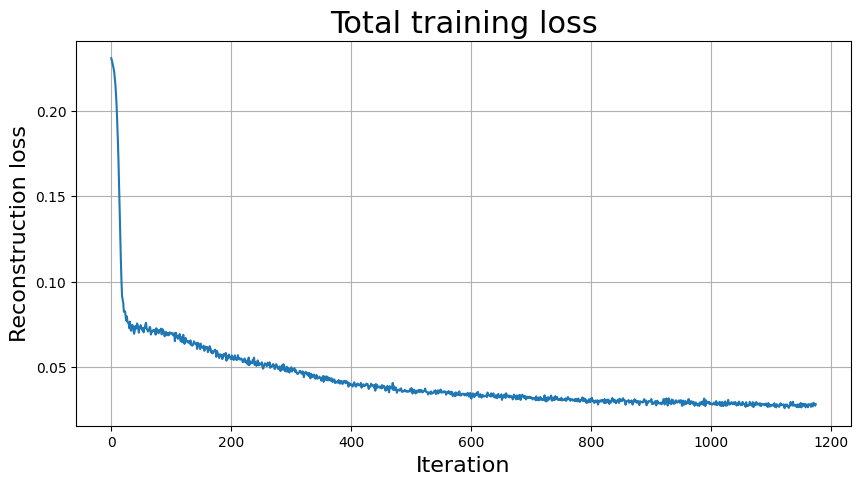

In [ ]:
# обучим модель с латентным кодом длины 8
model = AutoEncoder(8)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_model(model, train_dataloader, optimizer, device=device)

Для довольно хорошего сжатия картинок из MNIST'a хватает всего 8 латентных переменных!

## Латентное пространство

Главная ценность автоэнкодера как модели - его латентный код. Он крайне насыщенный, т.к. он должен сохранять как можно больше важной информации об объекте. Кроме того, само латентное пространство (множество латентных кодов всех объектов) - довольно плотное и отлично сохраняет структуру исходного пространства - например, похожие объекты в исходном пространстве будут находиться недалеко друг от друга в латентном пространстве.

В этой части мы проиллюстрируем эти свойства.

### Интерполяция латентных кодов

Интерполяция латентного кода - это визуализация процесса движения от одной точки латентного пространства к другой. Обычно интерполируют по прямой - соединяют две точки, соответствующие реальным объектам, отрезком и смотрят латентные коды через равные части этого отрезка. Для каждой промежуточной точки строят выход декодера.

Давайте возьмем два случайных объекта из выборки и построим интерполяцию между ними.

In [ ]:
x, _ = next(iter(train_dataloader))

x1 = x[0].to(device)
x2 = x[1].to(device)

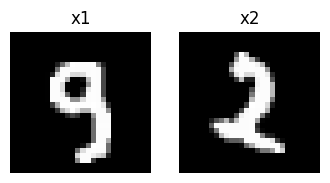

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(4, 2))

axs[0].axis("off")
axs[0].set_title("x1")
axs[0].imshow(x1[0].cpu().detach().numpy(), cmap="gray")
axs[1].axis("off")
axs[1].set_title("x2")
axs[1].imshow(x2[0].cpu().detach().numpy(), cmap="gray");

In [ ]:
# латентные коды объектов
z_1 = model.encode(x1[None, :, :, :])
z_2 = model.encode(x2[None, :, :, :])

# батч с интерполяцией этих латентных кодов по прямой в 11 точках
linspace = torch.linspace(0, 1, 11)[:, None].to(device)
z_linspace = z_2 * linspace + z_1 * (1 - linspace)

# восстановленные из латентных кодов изображения
x_linspace = model.decode(z_linspace)

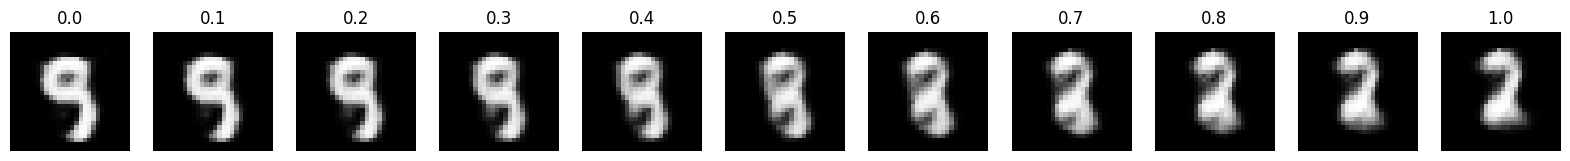

In [ ]:
# рисуем проинтерполированные объекты
fig, axs = plt.subplots(1, 11, figsize=(20, 20))

for i, d in enumerate(np.linspace(0, 1, 11)):
    axs[i].axis("off")
    axs[i].set_title(f"{d:.2}")
    axs[i].imshow(x_linspace[i, 0].cpu().detach().numpy(), cmap="gray")